In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import export_text, DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [26]:
df = pd.read_csv("stress_detection.csv", index_col=1)
df

,participant_id,PSS_score,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism,sleep_time,wake_time,sleep_duration,PSQI_score,call_duration,num_calls,num_sms,screen_on_time,skin_conductance,accelerometer,mobility_radius,mobility_distance
day,,,,,,,,,,,,,,,,,,,
1,1,34,2.322732,4.332193,1.185878,1.570213,3.782094,7.726792,5.190660,6.572069,1,3.924527,12,32,10.703714,3.115730,0.161717,1.145179,2.196851
2,1,37,1.761436,3.254120,3.907281,4.072512,1.997145,7.312674,6.170717,8.030168,4,58.318004,3,41,11.012939,0.959144,0.985587,1.021133,0.737825
3,1,30,3.025887,1.855002,2.045900,2.317493,3.619225,6.992060,5.318825,7.102420,1,4.941043,4,48,4.877372,3.311629,1.877445,0.478179,0.911673
4,1,16,1.948370,4.966676,3.345225,1.607756,3.583524,8.886914,8.061075,8.123294,3,0.295373,11,38,3.462956,0.625721,0.494921,0.630549,3.911418
5,1,32,3.343484,2.065936,3.137843,2.118061,2.567347,7.811705,7.312145,7.785143,3,22.300571,17,17,4.861046,0.622609,1.342600,0.254090,1.605132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,100,30,2.529821,2.339608,1.321208,4.204331,4.890738,8.823033,8.703758,8.661936,2,59.106125,0,1,11.339248,4.045863,1.694037,0.859401,4.123621
27,100,33,1.319100,4.500507,4.816983,2.416180,4.195933,5.260243,5.890244,6.456058,4,56.137068,12,17,10.694380,2.169768,1.657737,0.108480,2.242326
28,100,30,1.899102,3.930147,4.047799,3.163160,2.559401,6.425568,7.978066,7.188921,3,58.102473,13,21,8.646478,4.995654,1.046666,0.508623,2.088313


In [ ]:
# Primitive cross-validation. Separating randomly has the same effect.
# df_train = df.head(2500)
# df_test = df.tail(500)
# X_train, y_train = df_train.drop(columns=["PSS_score", "participant_id", "day"]), df_train.PSS_score
# X_test, y_test = df_test.drop(columns=["PSS_score", "participant_id", "day"]), df_test['PSS_score']

In [27]:
### Actual cross validation that we plan to use ###

# Get unique participant IDs
unique_ids = df.index.unique()

# Shuffle the IDs
np.random.seed(0) # Not truly random!
shuffled_ids = np.random.permutation(unique_ids)

# Split the IDs
n_train = int(len(shuffled_ids) * 0.8)
n_val = int(len(shuffled_ids) * 0.1)
n_test = len(shuffled_ids) - n_train - n_val

train_ids = shuffled_ids[:n_train]
val_ids = shuffled_ids[n_train:n_train + n_val]
test_ids = shuffled_ids[n_train + n_val:]

# Filter rows by IDs
train_data = df[df.index.isin(train_ids)]
val_data = df[df.index.isin(val_ids)]
test_data = df[df.index.isin(test_ids)]

# Print sizes
print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")

Train size: 2400
Validation size: 300
Test size: 300


In [32]:
train_data.index.unique()

Index([ 2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 23,
       24, 25, 27, 28, 29, 30],
      dtype='int64', name='day')

In [33]:
test_data.index.unique()

Index([13, 16, 22], dtype='int64', name='day')

In [35]:
val_data.index.unique()

Index([1, 4, 26], dtype='int64', name='day')

In [37]:
X_train, y_train = train_data.drop(columns=["PSS_score", "participant_id"]), train_data.PSS_score
X_val, y_val = val_data.drop(columns=["PSS_score", "participant_id"]), val_data['PSS_score']
X_test, y_test = test_data.drop(columns=["PSS_score", "participant_id"]), test_data['PSS_score']

In [38]:
best_score = float('inf')
best_params = None
results = []

max_depth_range = range(1, 21)  # Example: 1 to 20
min_impurity_decrease_range = np.arange(0.0, 0.5, 0.05)

# Loop through each of our parameters to do grid search by hand
for max_depth in max_depth_range:
    for min_impurity_decrease in min_impurity_decrease_range:
        # Create model
        model = DecisionTreeRegressor(
            criterion='squared_error',
            max_depth=max_depth,
            min_impurity_decrease=min_impurity_decrease
        )
        model.fit(X_train, y_train)
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        val_mse = mean_squared_error(y_val, y_val_pred)
        print(f"max_depth={max_depth}; min_impurity_decrease={min_impurity_decrease:.3}; val_mse={val_mse}")
        
        # Update results
        results.append({
            'max_depth': max_depth,
            'min_impurity_decrease': min_impurity_decrease,
            'val_mse': val_mse
        })
        if val_mse < best_score:
            best_score = val_mse
            best_params = {'max_depth': max_depth, 'min_impurity_decrease': min_impurity_decrease}

results_df = pd.DataFrame(results)
print(f"Best parameters: {best_params}")
print(f"Best validation MSE: {best_score}")


max_depth=1; min_impurity_decrease=0.0; val_mse=74.4637354573462
max_depth=1; min_impurity_decrease=0.05; val_mse=74.4637354573462
max_depth=1; min_impurity_decrease=0.1; val_mse=74.4637354573462
max_depth=1; min_impurity_decrease=0.15; val_mse=74.4637354573462
max_depth=1; min_impurity_decrease=0.2; val_mse=74.4637354573462
max_depth=1; min_impurity_decrease=0.25; val_mse=74.4637354573462
max_depth=1; min_impurity_decrease=0.3; val_mse=74.4637354573462
max_depth=1; min_impurity_decrease=0.35; val_mse=74.4637354573462
max_depth=1; min_impurity_decrease=0.4; val_mse=74.07082847222223
max_depth=1; min_impurity_decrease=0.45; val_mse=74.07082847222223
max_depth=2; min_impurity_decrease=0.0; val_mse=75.17022380329402
max_depth=2; min_impurity_decrease=0.05; val_mse=75.17022380329402
max_depth=2; min_impurity_decrease=0.1; val_mse=75.17022380329402
max_depth=2; min_impurity_decrease=0.15; val_mse=75.17022380329402
max_depth=2; min_impurity_decrease=0.2; val_mse=75.17022380329402
max_depth=2

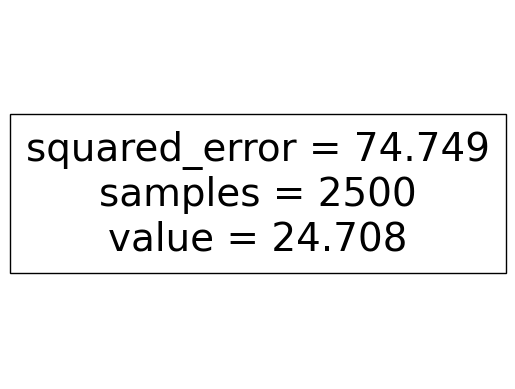

In [7]:
model = DecisionTreeRegressor(criterion='squared_error', max_depth=1, min_impurity_decrease=0.35000000000000003)
# model = DecisionTreeRegressor(criterion='squared_error', max_depth=2)
model.fit(X_train, y_train)
fig = plt.figure()
_ = tree.plot_tree(model,feature_names=X_train.columns)
# print(export_text(model, feature_names=X.columns))

# Notes from prof:
# Check MSE train and MSE test against each other
# try min_impurity_decrease in regressor
# only show first 3 layers on slides and interpret them, bigger font (make readable)
# maybe decrease max_depth as last step

In [ ]:
### MSE of our model (predicting the mean for everything) on test data ###
y_test_hat = model.predict(X_test)
mean_squared_error(y_test, y_test_hat)

71.496208

In [9]:
### Creating a tree with max_depth=4 performs worse than a model that guesses the mean ###
model = DecisionTreeRegressor(criterion='squared_error', max_depth=4)
model.fit(X_train, y_train)

y_model_val_hat = model.predict(X_test)
mean_squared_error(y_true=y_test, y_pred=y_model_val_hat)

77.77159649280586

In [10]:
### A linear model still does worse than guessing the mean each time ###
from sklearn.linear_model import LinearRegression
used_variables = ["Openness", "Neuroticism", "mobility_distance"]
X_train2 = X_train[used_variables]
X_test2 = X_test[used_variables]
linear_model = LinearRegression()
linear_model.fit(X_train2, y_train)
y_hat2_linear = linear_model.predict(X_test2)
mean_squared_error(y_true=y_test, y_pred=y_hat2_linear)

71.73701964387676

In [42]:
df.columns

Index(['participant_id', 'PSS_score', 'Openness', 'Conscientiousness',
       'Extraversion', 'Agreeableness', 'Neuroticism', 'sleep_time',
       'wake_time', 'sleep_duration', 'PSQI_score', 'call_duration',
       'num_calls', 'num_sms', 'screen_on_time', 'skin_conductance',
       'accelerometer', 'mobility_radius', 'mobility_distance'],
      dtype='object')

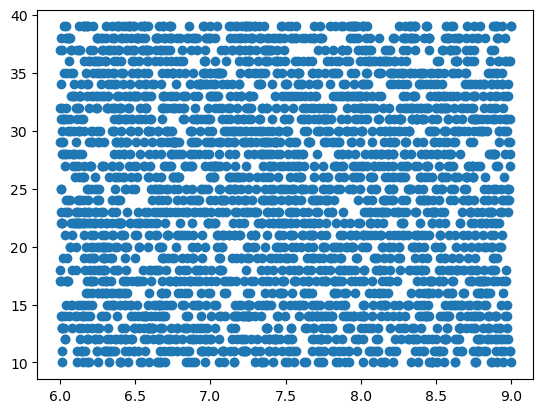

In [43]:
plt.figure()
plt.scatter(df["sleep_duration"], df["PSS_score"])

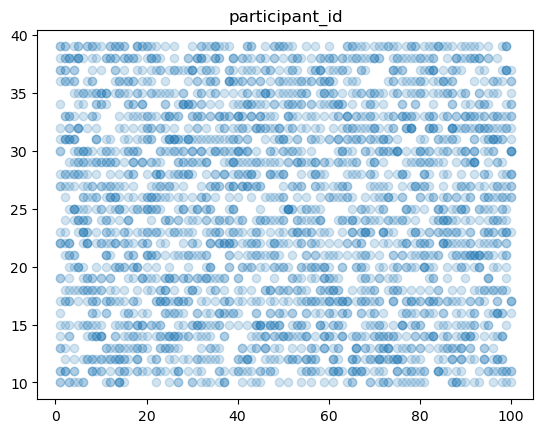

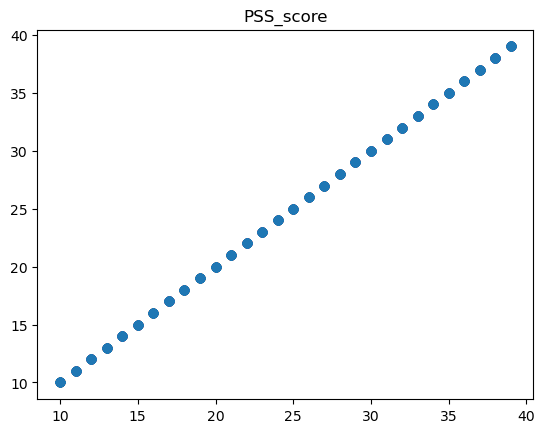

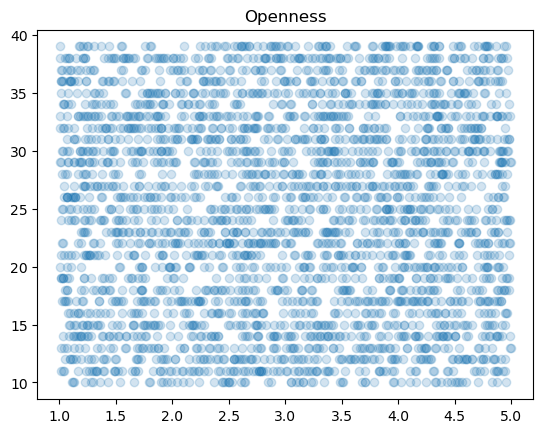

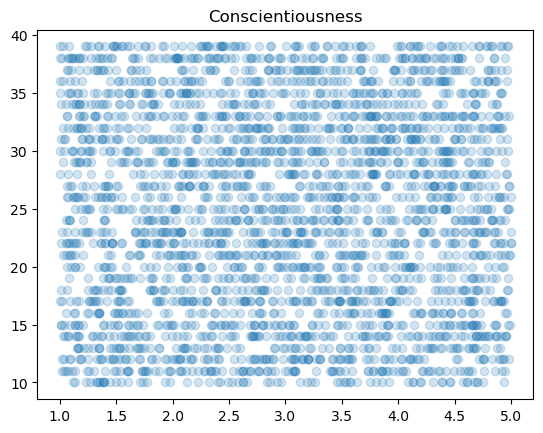

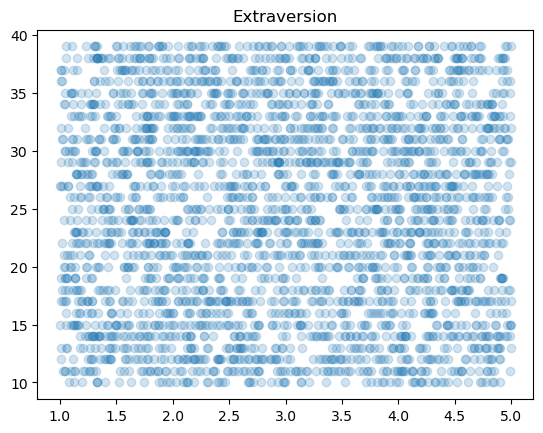

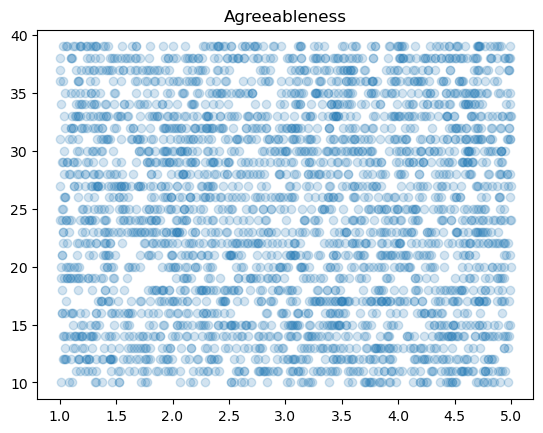

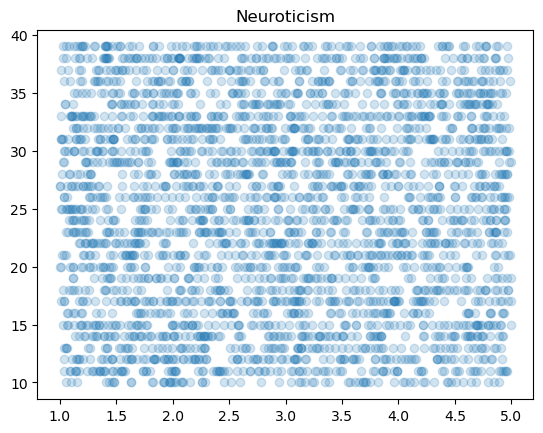

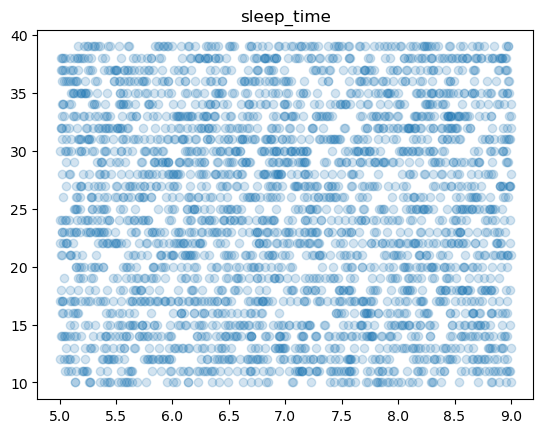

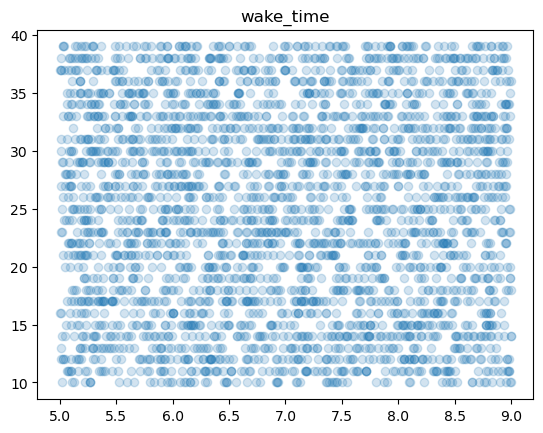

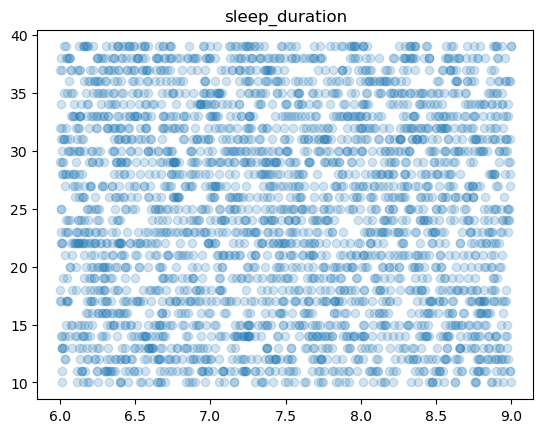

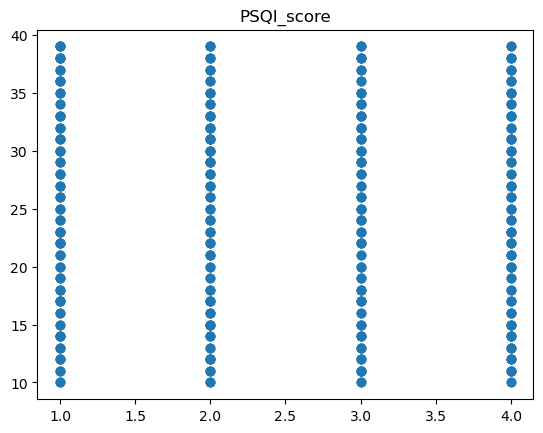

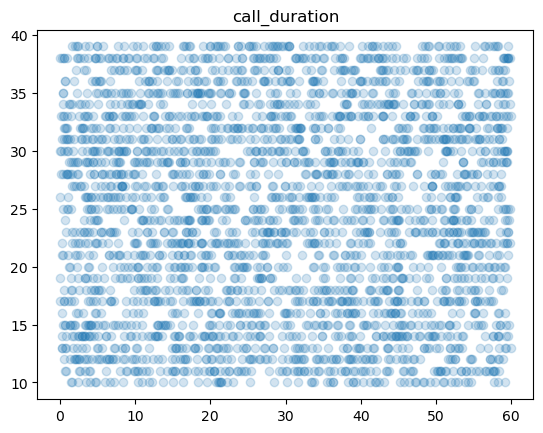

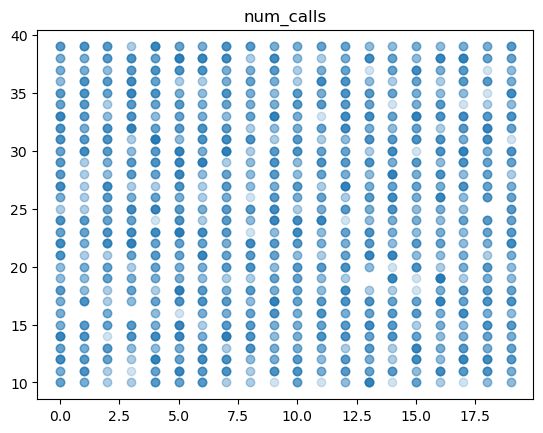

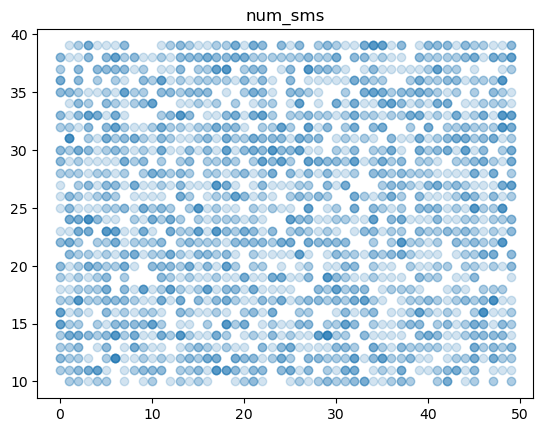

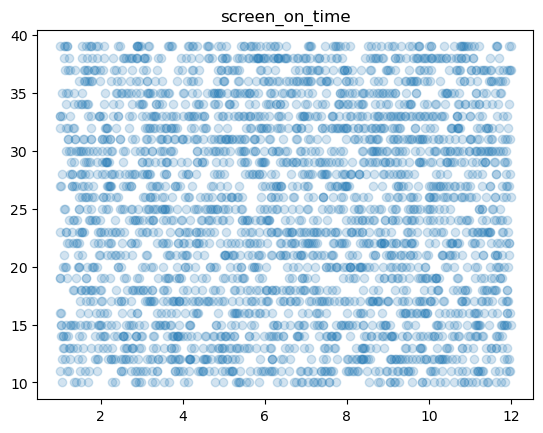

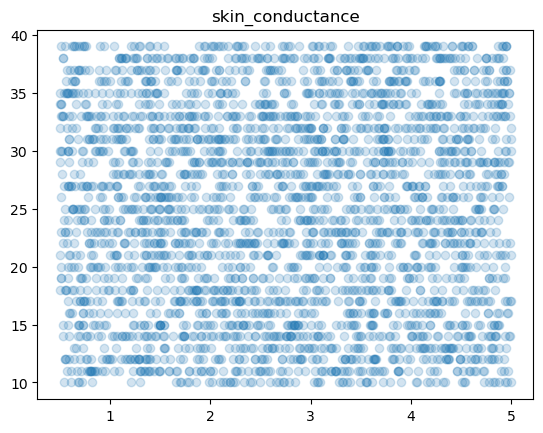

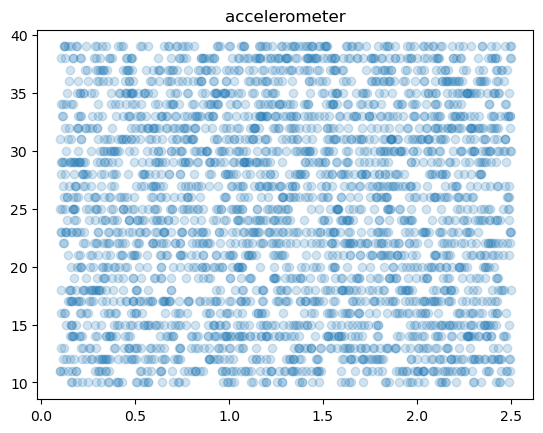

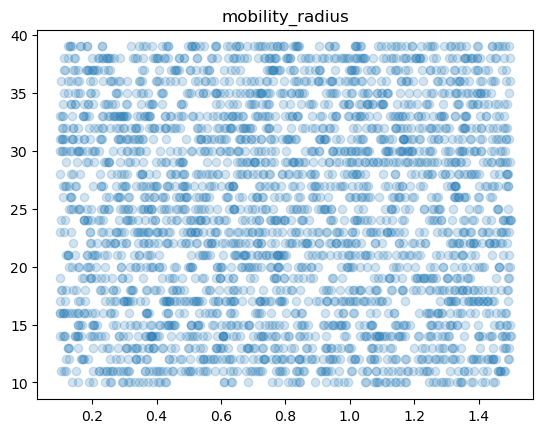

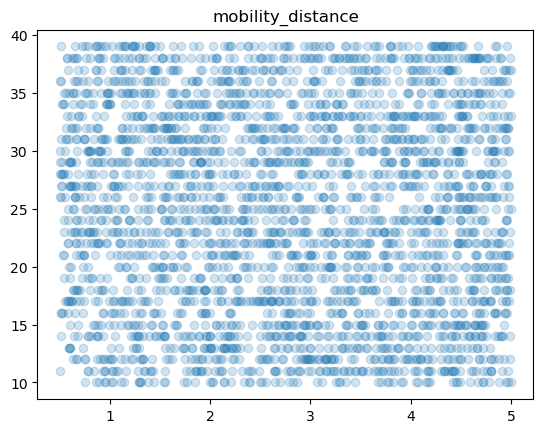

In [47]:
for var in df.columns:
    plt.figure()
    plt.title(var)
    plt.scatter(df[var], df["PSS_score"], alpha=0.2)